In [1]:
import numpy as np
import glob
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from skimage.metrics import normalized_root_mse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

import albumentations as album

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import os
os.chdir('/content/drive/MyDrive/Machine_Learning/Crack_Detection') 
!pwd
#%ls

/content/drive/MyDrive/Machine_Learning/Crack_Detection


In [4]:
# Normalization parameters for pre-trained PyTorch models
#mean = np.array([0.485, 0.456, 0.406])
#std = np.array([0.229, 0.224, 0.225])
class ImageDataset(Dataset):
    def __init__(self, files, lr_shape, augmentation=None):
        lr_height, lr_width = lr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
        self.files = files
        self.augmentation = augmentation
    
    def __getitem__(self, index):
        img = cv2.imread(self.files[index % len(self.files)], 0)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=img)
            img = sample['image']
        img_lr = self.lr_transform(img)
        return {"lr": img_lr}

    def __len__(self):
        return len(self.files)

# Defining Augmentations
def get_training_augmentation():
    train_transform = [    
        album.Resize(height=128, width=128, always_apply=True, p=1, interpolation=cv2.INTER_AREA),
        album.OneOf(
            [album.HorizontalFlip(p=1),
             album.VerticalFlip(p=1),
             album.RandomRotate90(p=1),
            ], p=0.5),
    ]
    return album.Compose(train_transform)

def get_test_augmentation():
    train_transform = [    
        album.Resize(height=128, width=128, always_apply=True, p=1, interpolation=cv2.INTER_AREA)]
    return album.Compose(train_transform)

# Configure data loader
dataset_path = "data/train/Negative"
lr_shape=(128,128)
batch_size=64
train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.tif*")), test_size=0.1, random_state=1)
train_loader = DataLoader(ImageDataset(train_paths, lr_shape=lr_shape, augmentation=get_training_augmentation()), batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)#augmentation=get_training_augmentation()
test_loader  = DataLoader(ImageDataset(test_paths, lr_shape=lr_shape, augmentation=get_test_augmentation()), batch_size=64, shuffle=True, num_workers=2, drop_last=True)

# Configure valid data loader
dataset_path = "data/train/Positive"
valid_loader = DataLoader(ImageDataset(glob.glob(dataset_path + "/*.tif*"), lr_shape=lr_shape, augmentation=get_test_augmentation()), batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

In [5]:
print(len(train_loader), len(test_loader), len(valid_loader))

17 1 9


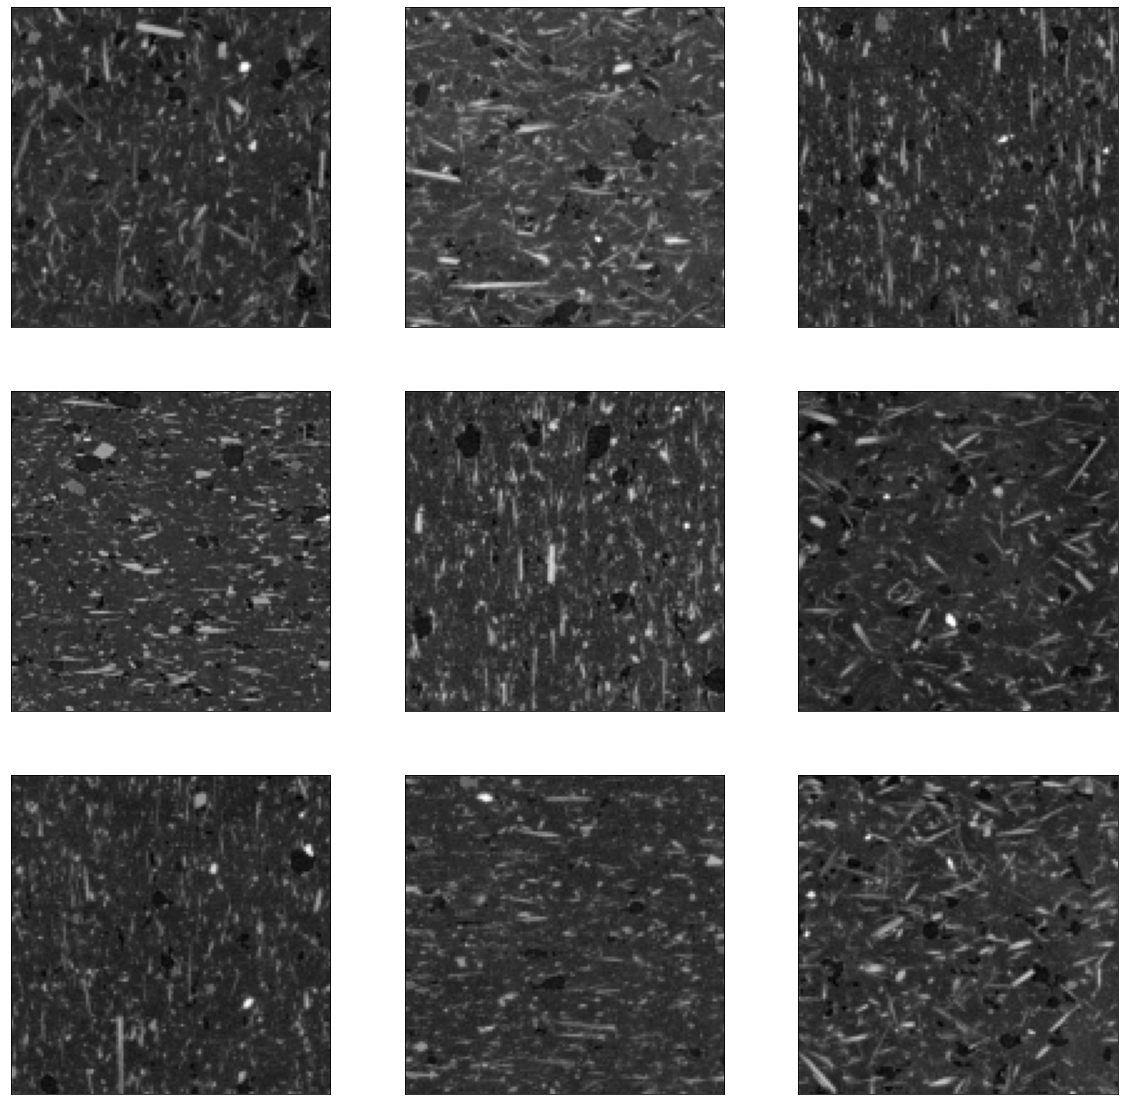

In [6]:
def imshow(img):
    plt.imshow(np.squeeze(np.transpose(img, (1, 2, 0))), cmap = "gray", vmin= np.min(img), vmax=np.max(img)) 

#Obtain one batch of training images
dataiter = iter(train_loader)
imgs = dataiter.next()
images = imgs["lr"]
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(20, 20))
# display 9 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [7]:
features = 32#100
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
 
        # encoder
        self.conv1 = nn.Sequential(nn.Conv2d(1, 64, 3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(True), nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64*2, 3, stride=1, padding=1), nn.BatchNorm2d(64*2), nn.ReLU(True), nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 64*3, 3, stride=1, padding=1), nn.BatchNorm2d(64*3), nn.ReLU(True), nn.MaxPool2d(2, 2))
        self.conv4 = nn.Sequential(nn.Conv2d(64*3, 64*4, 3, stride=1, padding=1), nn.BatchNorm2d(64*4), nn.ReLU(True), nn.MaxPool2d(2, 2))
        self.conv5 = nn.Sequential(nn.Conv2d(64*4, 64*5, 3, stride=1, padding=1), nn.BatchNorm2d(64*5), nn.ReLU(True), nn.MaxPool2d(2, 2))
        self.conv6 = nn.Sequential(nn.Conv2d(64*5, 64*6, 3, stride=1, padding=1), nn.BatchNorm2d(64*6), nn.ReLU(True), nn.MaxPool2d(2, 2), nn.Flatten())
        self.conv7 = nn.Sequential(nn.Linear(in_features=4*64*6, out_features=features))

        # decoder   
        self.conv7_T = nn.Sequential(nn.ConvTranspose2d(features, 64*6, 4, stride=2, padding=1), nn.BatchNorm2d(64*6), nn.ReLU(True))
        self.conv6_T = nn.Sequential(nn.ConvTranspose2d(64*6, 64*5, 4, stride=2, padding=1), nn.BatchNorm2d(64*5), nn.ReLU(True))
        self.conv5_T = nn.Sequential(nn.ConvTranspose2d(64*5, 64*4, 4, stride=2, padding=1), nn.BatchNorm2d(64*4), nn.ReLU(True))
        self.conv4_T = nn.Sequential(nn.ConvTranspose2d(64*4, 64*3, 4, stride=2, padding=1), nn.BatchNorm2d(64*3), nn.ReLU(True))
        self.conv3_T = nn.Sequential(nn.ConvTranspose2d(64*3, 64*2, 4, stride=2, padding=1), nn.BatchNorm2d(64*2), nn.ReLU(True))
        self.conv2_T = nn.Sequential(nn.ConvTranspose2d(64*2, 64, 4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(True))  
        self.conv1_T = nn.Sequential(nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1))
 
    def encoder(self, x):
        # encoding
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        return x

    def decoder(self, z):
        # decoding
        x = self.conv7_T(z.view(-1, features, 1, 1))
        x = self.conv6_T(x)
        x = self.conv5_T(x)
        x = self.conv4_T(x)
        x = self.conv3_T(x)
        x = self.conv2_T(x)       
        x = self.conv1_T(x)
        return x

    def forward (self, x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction

#Instantiate the model
model = ConvAutoencoder()

In [8]:
#Loss function
criterion = nn.L1Loss() #nn.MSELoss()#nn.BCELoss()#torch.nn.BCEWithLogitsLoss()#

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [9]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)
summary(model,(1,128,128))

# Load pretrained models
load_pretrained_models = True
model_path = "AEC_model.pth"
if load_pretrained_models:
    model.load_state_dict(torch.load(model_path,map_location=device))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
       BatchNorm2d-6          [-1, 128, 64, 64]             256
              ReLU-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 192, 32, 32]         221,376
      BatchNorm2d-10          [-1, 192, 32, 32]             384
             ReLU-11          [-1, 192, 32, 32]               0
        MaxPool2d-12          [-1, 192, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         442,624
      BatchNorm2d-14          [-1, 

In [10]:
train_losses=[]
val_min = 1

#Epochs
n_epochs = 0

for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0.0

    #Training
    for i, imgs in enumerate(train_loader):
        images = imgs["lr"].type(Tensor)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # append training and validation loss
    train_losses.append(train_loss/len(train_loader))

    if (epoch)%5 == 0:
        #validation 
        model.eval()
        val_losses=0
        with torch.no_grad():
            #Batch of test images
            for j, img in enumerate(test_loader):
                image = img["lr"].type(Tensor)
                #Sample outputs
                output = model(image)

                val_loss = criterion(output, image)
                val_losses += val_loss.item()

            val_losses = val_losses/len(test_loader)
        if val_losses < val_min:
            torch.save(model.state_dict(), "AEC_model_best.pth")
            val_min = val_losses

        print('Epoch: {} \tTraining Loss: {:.5f}, \tValidation Loss: {:.5f}'.format(epoch, train_loss/len(train_loader), val_losses))

    # Save model checkpoints
    if (epoch)%50 == 0:
        torch.save(model.state_dict(), f"AEC_model_{epoch}.pth")
        print('save model!')

In [18]:
plt.figure()
plt.plot(range(len(train_losses)), train_losses)
plt.title('Training Loss')
plt.show()

Original Images


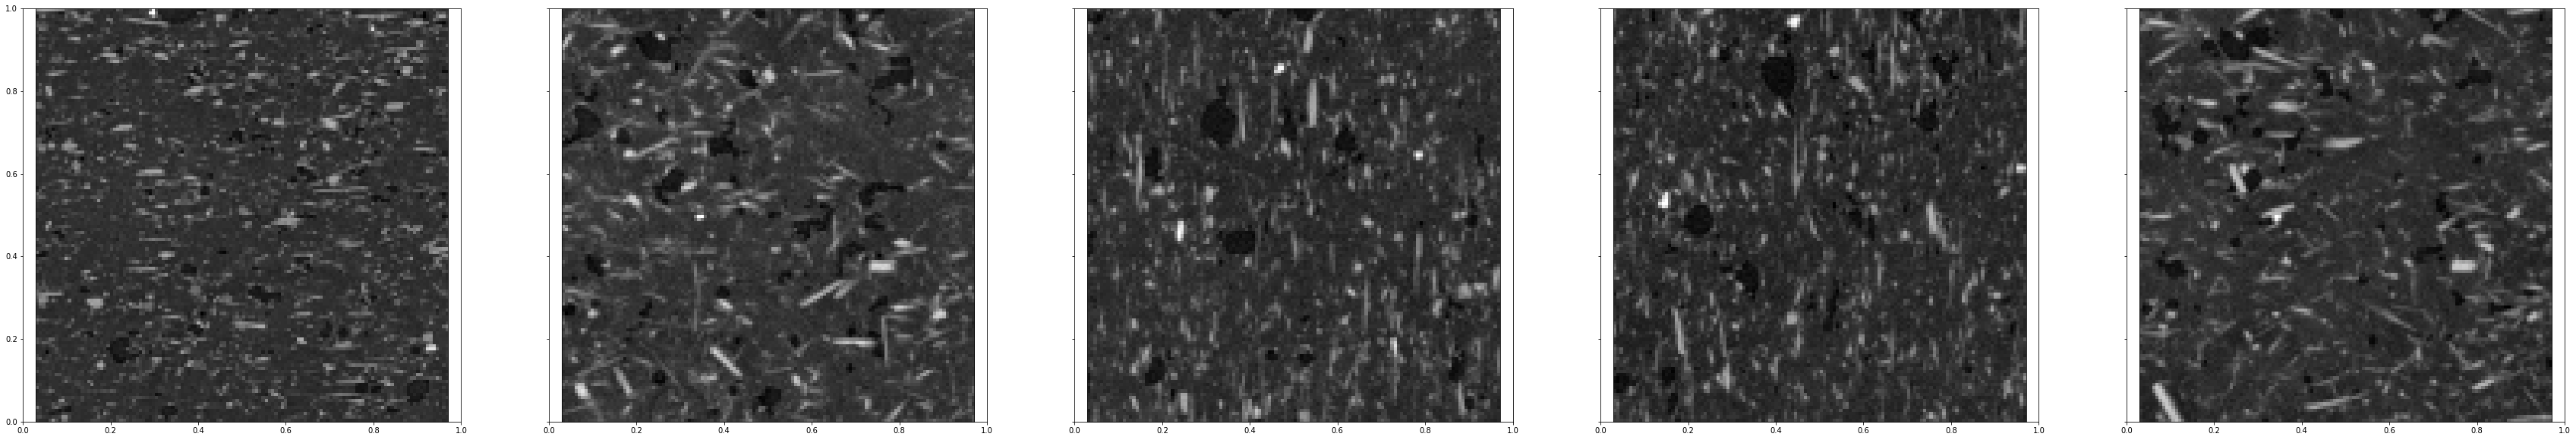

Reconstructed Images


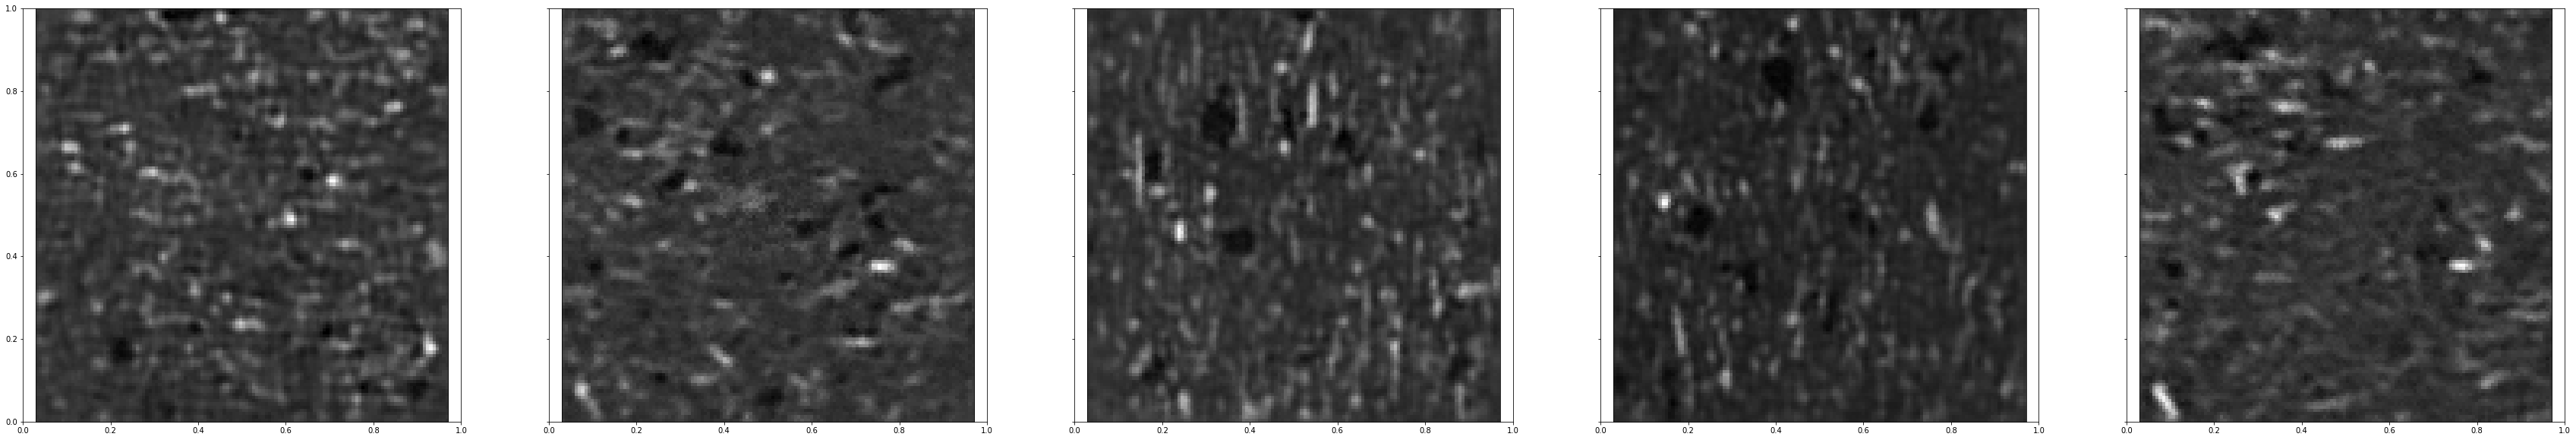

64 0.10360684679036795 0.20737560436936087


In [12]:
#Batch of test images
dataiter = iter(test_loader)
imgs = dataiter.next()
images = imgs["lr"]

#Sample outputs
model.eval()
with torch.no_grad():
  output = model(images.type(Tensor))
  output = output.cpu()
  images = images.numpy()
  output = output.view(64, 1, 128, 128)
  output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(60,10))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(60,10))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 

#Loss
Loss_N =[]
for idx in np.arange(64):
  Loss_N.append(normalized_root_mse(images[idx],output[idx]))
print(len(Loss_N),  min(Loss_N), max(Loss_N))

Original Images


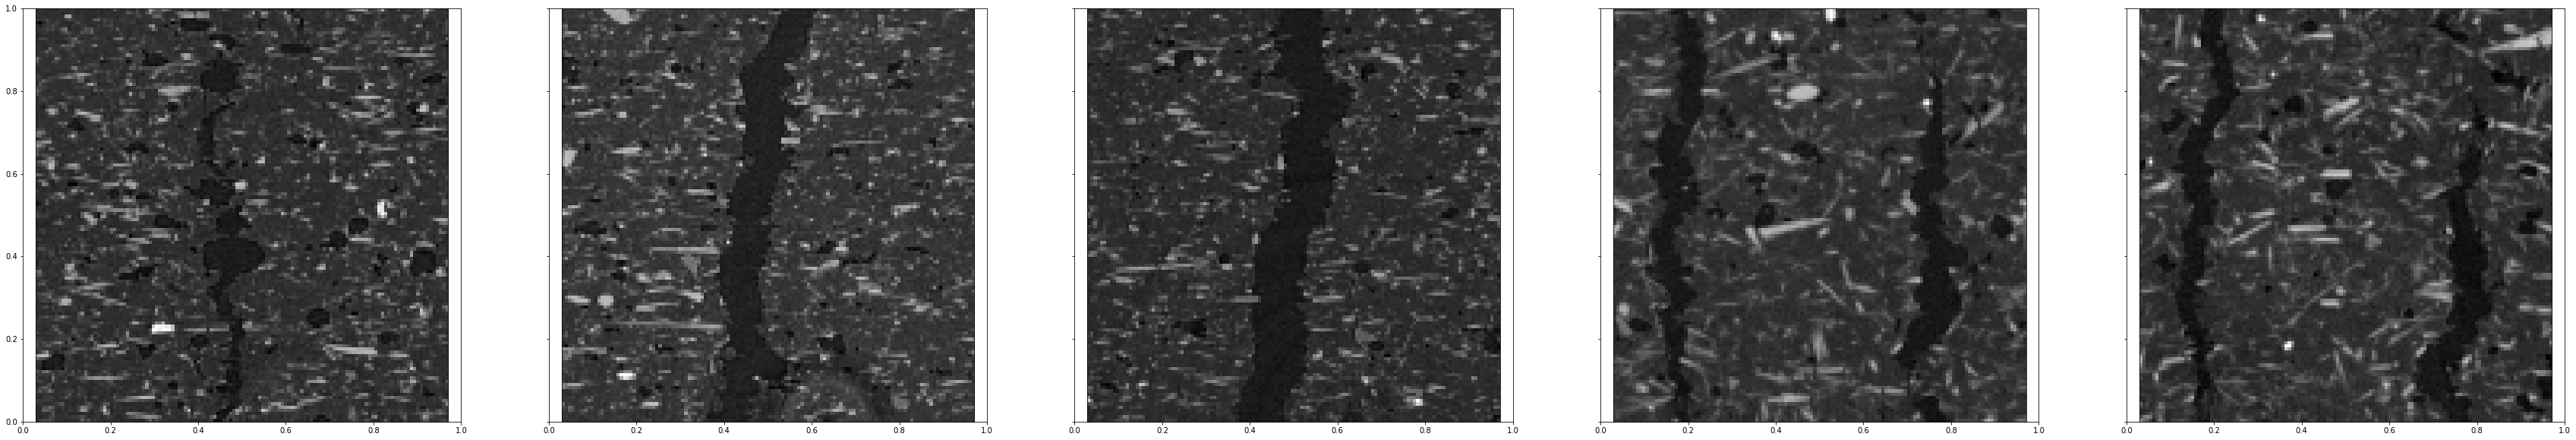

Reconstructed Images


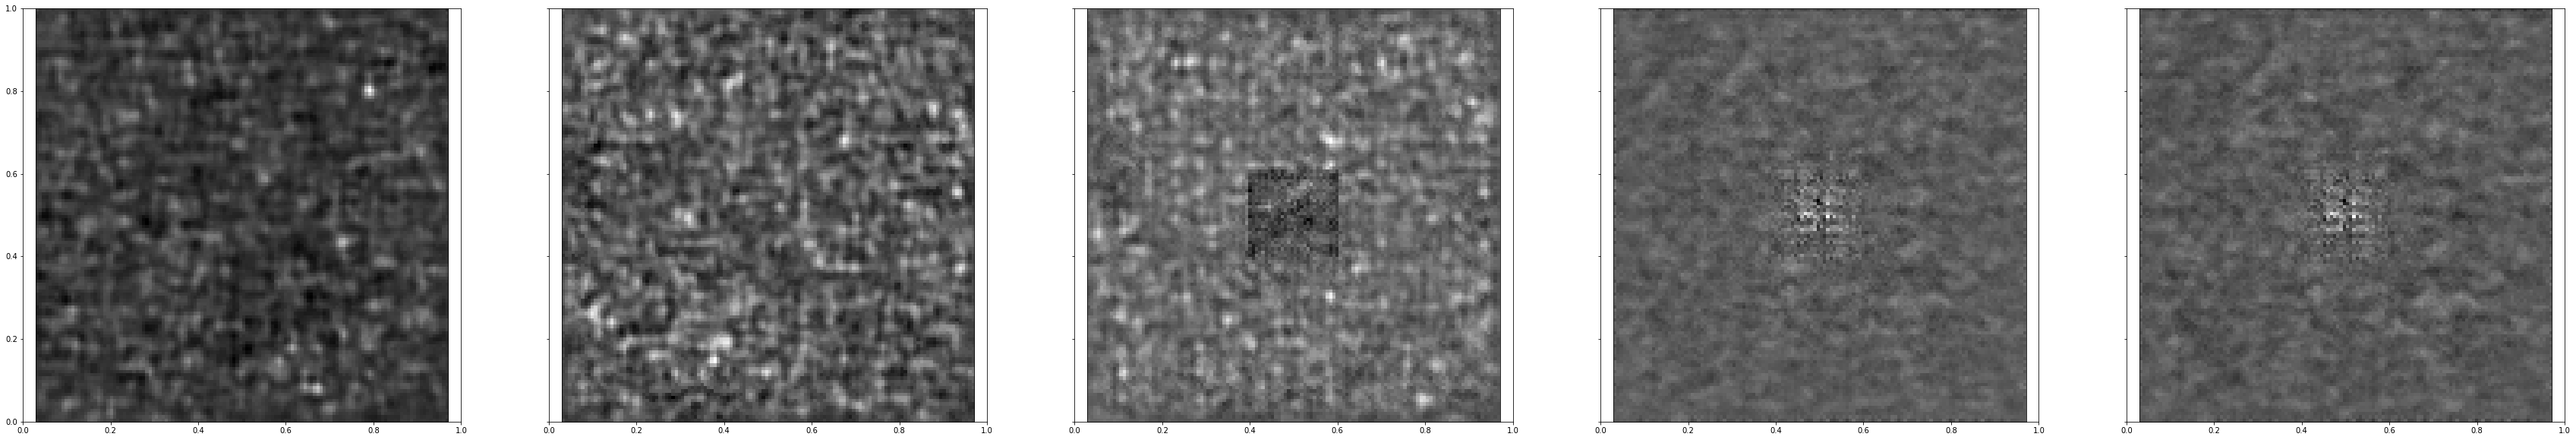

64 0.16836668108684313 0.603737063051886


In [13]:
#Batch of valid images
dataiter = iter(valid_loader)
imgs = dataiter.next()
images = imgs["lr"]

#Sample outputs
model.eval()
with torch.no_grad():
  output = model(images.type(Tensor))
  output = output.cpu()
  images = images.numpy()
  output = output.view(batch_size, 1, 128, 128)
  output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(60,10))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(60,10))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 

#Loss
Loss_P =[]
for idx in np.arange(batch_size):
  Loss_P.append(normalized_root_mse(images[idx],output[idx]))
print(len(Loss_P),  min(Loss_P), max(Loss_P))

In [17]:
np.sum(np.asarray(Loss_N) >0.18)

4

In [18]:
np.sum(np.asarray(Loss_P) <0.18)

2